<a href="https://colab.research.google.com/github/nickname8888/Quaternions-LPI/blob/main/nst_tf_docs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
# content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

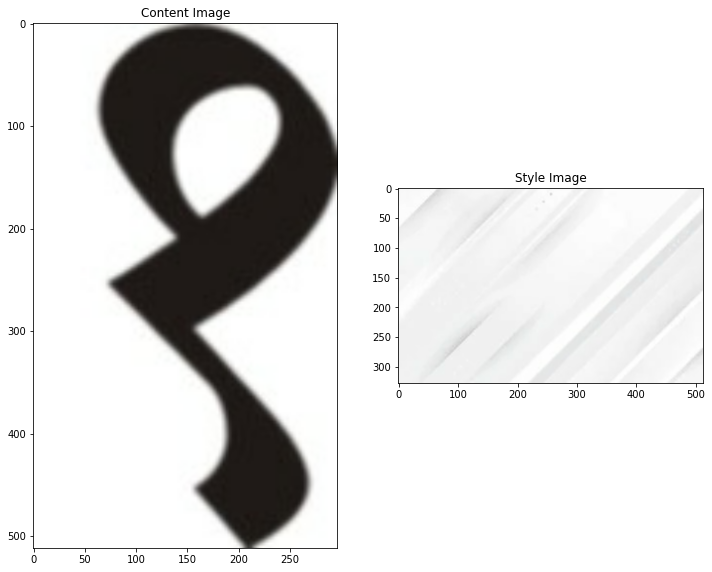

In [ ]:
# content_image = load_img(content_path)
# style_image = load_img(style_path)

content_image = load_img('/content/drive/MyDrive/datasets/models/tf-nst/11.jpg')
style_image = load_img('/content/drive/MyDrive/datasets/models/tf-nst/style6.jpg')

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

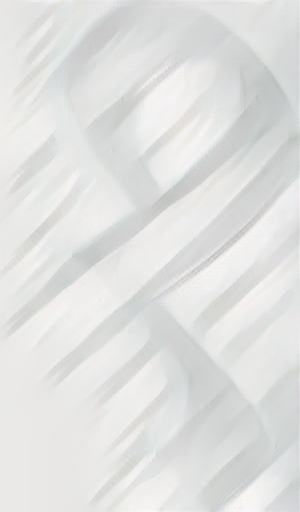

In [ ]:
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [ ]:
#Define content and style representations

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('loupe', 0.08633556),
 ('face_powder', 0.07678701),
 ('pick', 0.06226036),
 ('puck', 0.046497453),
 ('corkscrew', 0.040595345)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_10
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 327, 512, 64)
  min:  0.0
  max:  874.3656
  mean:  33.090527

block2_conv1
  shape:  (1, 163, 256, 128)
  min:  0.0
  max:  3260.3943
  mean:  179.7412

block3_conv1
  shape:  (1, 81, 128, 256)
  min:  0.0
  max:  10239.625
  mean:  121.66655

block4_conv1
  shape:  (1, 40, 64, 512)
  min:  0.0
  max:  11818.976
  mean:  452.7354

block5_conv1
  shape:  (1, 20, 32, 512)
  min:  0.0
  max:  1418.6617
  mean:  25.570494



In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  137333.4
    mean:  472.07706

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  234201.44
    mean:  12270.141

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  457141.25
    mean:  10129.289

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3535574.5
    mean:  150374.98

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  71361.59
    mean:  818.45496

Contents:
   block5_conv2
    shape:  (1, 32, 18, 512)
    min:  0.0
    max:  572.4372
    mean:  8.058956


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
# train_step(image)
# train_step(image)
# train_step(image)
# tensor_to_image(image)

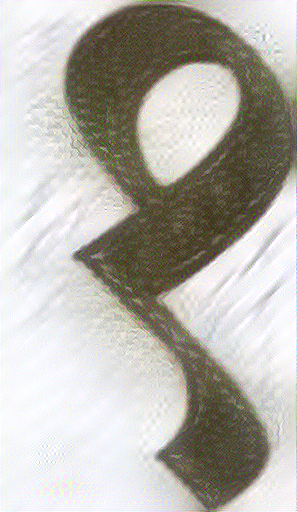

step  126  done in  4.870589017868042
step  127  done in  4.825788736343384
step  128  done in  4.800363779067993
step  129  done in  4.792243480682373
step  130  done in  4.745177745819092
step  131  done in  4.797575235366821
step  132  done in  4.754190444946289
step  133  done in  4.773058891296387
step  134  done in  4.756706953048706
step  135  done in  4.789545297622681
step  136  done in  5.1470465660095215
step  137  done in  4.7793192863464355
step  138  done in  4.816435098648071
step  139  done in  4.83012843132019
step  140  done in  4.790463924407959
step  141  done in  4.81074857711792
step  142  done in  4.8006370067596436
step  143  done in  4.794811725616455
step  144  done in  4.82950496673584
step  145  done in  4.7633585929870605
step  146  done in  4.831116437911987
step  147  done in  4.825922966003418
step  148  done in  4.808513402938843
step  149  done in  4.766994476318359
Total time: 728.6


In [ ]:
import cv2
import time
startt = time.time()

# epochs = 5
# steps_per_epoch = 100

# step = 0
# for n in range(epochs):
#   for m in range(steps_per_epoch):
#     step += 1
#     train_step(image)
#     print(".", end='', flush=True)
#   display.clear_output(wait=True)
#   display.display(tensor_to_image(image))
#   print("Train step: {}".format(step))

for i in range(150):
  start = time.time()
  train_step(image)
  end = time.time()
  print('step ', i, ' done in ', end-start)
  if(i%25==0):
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    tensor_to_image(image).save('/content/drive/MyDrive/datasets/models/nst-tf-docs/11+style6-step'+str(i+0)+'.jpg')

endt = time.time()
print("Total time: {:.1f}".format(endt-startt))

In [ ]:
tensor_to_image(image).save('/content/drive/MyDrive/datasets/models/nst-tf-docs/11+style6-step'+str(300-1)+'.jpg')

In [ ]:
#there is more in the docs
#https://www.tensorflow.org/tutorials/generative/style_transfer